In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.utils import shuffle
import json

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.16.2


In [2]:
# -----------------------------
# SETTINGS
# -----------------------------
model_version = "v10"
metadata_path = "UrbanSound8K/metadata/UrbanSound8K.csv"
audio_base = "UrbanSound8K/audio"

VALIDATION_FOLD = 10
TRAIN_FOLDS = [1, 2, 3, 4, 5, 6, 7, 8, 9]

selected_ids = [1,3,4,5,6,7,8,9]
sr = 16000
duration = 4
samples_per_clip = sr * duration

# --- Using 64-mels, 126-frames input ---
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048
FMAX = sr // 2

id_to_label = {cid: i for i, cid in enumerate(selected_ids)}

In [3]:
# -----------------------------
# DATA LOADING & FEATURE EXTRACTION
# -----------------------------

def extract_features(file_path):
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
        if len(y) < samples_per_clip:
            y = np.pad(y, (0, samples_per_clip - len(y)))
        else:
            y = y[:samples_per_clip]

        mel_spec = librosa.feature.melspectrogram(
            y=y, 
            sr=sr, 
            n_mels=N_MELS, 
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            win_length=WIN_LENGTH,
            fmax=FMAX
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel = log_mel.T 
        return log_mel
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None


def load_data_from_folds(df, folds_list):
    X, y = [], []
    fold_df = df[df['fold'].isin(folds_list)]
    for _, row in fold_df.iterrows():
        file_path = os.path.join(audio_base, f"fold{row['fold']}", row["slice_file_name"])
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(id_to_label[row["classID"]])
    return np.array(X), np.array(y)

In [5]:
# -----------------------------
# DATA PREPARATION & NORMALIZATION
# -----------------------------
df = pd.read_csv(metadata_path)
df = df[df["classID"].isin(selected_ids)]

print(f"Loading training data (folds {TRAIN_FOLDS})...")
X_train, y_train = load_data_from_folds(df, TRAIN_FOLDS)
print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

print(f"Loading validation data (fold {VALIDATION_FOLD})...")
X_val, y_val = load_data_from_folds(df, [VALIDATION_FOLD])
print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")

GLOBAL_MEAN = np.mean(X_train)
GLOBAL_STD = np.std(X_train)
epsilon = 1e-9 

print("\n" + "="*30)
print("DEPLOYMENT CONSTANTS (for C++ code):")
print(f"GLOBAL_MEAN: {GLOBAL_MEAN:.8f}")
print(f"GLOBAL_STD: {GLOBAL_STD:.8f}")
print("="*30 + "\n")

norm_constants = {'mean': float(GLOBAL_MEAN), 'std': float(GLOBAL_STD)}
with open(f'{model_version}/normalization_constants.json', 'w') as f:
    json.dump(norm_constants, f)

X_train_norm = (X_train - GLOBAL_MEAN) / (GLOBAL_STD + epsilon)
X_val_norm = (X_val - GLOBAL_MEAN) / (GLOBAL_STD + epsilon)

X_train_norm = X_train_norm[..., np.newaxis]
X_val_norm = X_val_norm[..., np.newaxis]

input_shape = X_train_norm.shape[1:]
num_classes = len(id_to_label)

print(f"Input shape for model: {input_shape}")
print(f"Number of classes: {num_classes}")

Loading training data (folds [1, 2, 3, 4, 5, 6, 7, 8, 9])...
Training data shape: X=(6095, 126, 64), y=(6095,)
Loading validation data (fold 10)...
Validation data shape: X=(637, 126, 64), y=(637,)

DEPLOYMENT CONSTANTS (for C++ code):
GLOBAL_MEAN: -38.72291183
GLOBAL_STD: 22.35516930

Input shape for model: (126, 64, 1)
Number of classes: 8


In [6]:
# -----------------------------
# MODEL ARCHITECTURE (v10 - Robust Conv2D)
# ----------------------------
from tensorflow.keras import regularizers
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        
        # --- Block 1: Low level features ---
        # Stride 2 in the first layer reduces memory footprint immediately
        tf.keras.layers.Conv2D(24, (3,3), strides=(1,1), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        # --- Block 2: Mid level features ---
        tf.keras.layers.Conv2D(48, (3,3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        # SpatialDropout drops entire feature maps, better for Audio/Images than standard Dropout
        tf.keras.layers.SpatialDropout2D(0.1), 

        # --- Block 3: High level features ---
        tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.SpatialDropout2D(0.1),
        
        # --- Block 4: Deep features ---
        # We add one more block to capture longer time dependencies
        tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        
        # Global Pooling reduces the 3D tensor to 1D vector
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # --- Classification Head ---
        # L2 Regularization helps keep weights small, improving Quantization accuracy
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Start slightly higher, LR scheduler will lower it
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", "sparse_top_k_categorical_accuracy"]
    )
    return model

In [7]:
# -----------------------------
# MODEL TRAINING
# -----------------------------

model = build_model(input_shape, num_classes)
model.summary()

checkpoint_path = f"{model_version}/best_model.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5,
        verbose=1, 
        min_lr=1e-7
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        verbose=1, 
        restore_best_weights=True
    )
]

X_train_norm_shuffled, y_train_shuffled = shuffle(X_train_norm, y_train, random_state=42)

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train_norm_shuffled,
    y_train_shuffled,
    epochs=75,
    batch_size=32,
    validation_data=(X_val_norm, y_val),
    callbacks=callbacks
)

print("\nLoading best model from checkpoint...")
best_model = tf.keras.models.load_model(checkpoint_path)

print("Evaluating best model on validation set (Fold 10):")
val_loss, val_acc, val_top_k_acc = best_model.evaluate(X_val_norm, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Top-3 Accuracy: {val_top_k_acc:.4f}")

2025-11-23 23:45:45.289369: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-23 23:45:45.291436: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-23 23:45:45.291653: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-23 23:45:45.291704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-23 23:45:45.291758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 64, 24)    │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 64, 24)    │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 32, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 32, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 31, 16, 48)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 16, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 15, 8, 64)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,056 (476.78 KB)

 Trainable params: 121,528 (474.72 KB)

 Non-trainable params: 528 (2.06 KB)


--- Starting Model Training ---
Epoch 1/75


2025-11-23 23:45:47.386894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3821 - loss: 1.7783 - sparse_top_k_categorical_accuracy: 0.8921
Epoch 1: val_loss improved from None to 3.21546, saving model to v10/best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.4592 - loss: 1.5637 - sparse_top_k_categorical_accuracy: 0.9339 - val_accuracy: 0.0581 - val_loss: 3.2155 - val_sparse_top_k_categorical_accuracy: 0.7017 - learning_rate: 0.0010
Epoch 2/75
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5827 - loss: 1.2329 - sparse_top_k_categorical_accuracy: 0.9659
Epoch 2: val_loss improved from 3.21546 to 2.35626, saving model to v10/best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5929 - loss: 1.2061 - sparse_top_k_categorical_accuracy: 0.9674 - val_accuracy: 0.4349 - val_loss: 2.3563 - val_sparse_top_k_categorical_accuracy: 0.8053 - learning_rate: 0.0010
Epoch 3/75
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6637 - loss: 1.0161 - sparse_top_k_cat

Running predictions on validation set (Fold 10) for analysis...
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

--- Classification Report ---

               precision    recall  f1-score   support

     car_horn       0.88      0.91      0.90        33
     dog_bark       0.82      0.87      0.84       100
     drilling       0.95      0.71      0.81       100
engine_idling       0.95      0.86      0.90        93
     gun_shot       0.97      1.00      0.98        32
   jackhammer       0.72      0.99      0.83        96
        siren       0.97      0.73      0.84        83
 street_music       0.88      0.97      0.92       100

     accuracy                           0.87       637
    macro avg       0.89      0.88      0.88       637
 weighted avg       0.88      0.87      0.87       637


--- Confusion Matrix (Percentages) ---


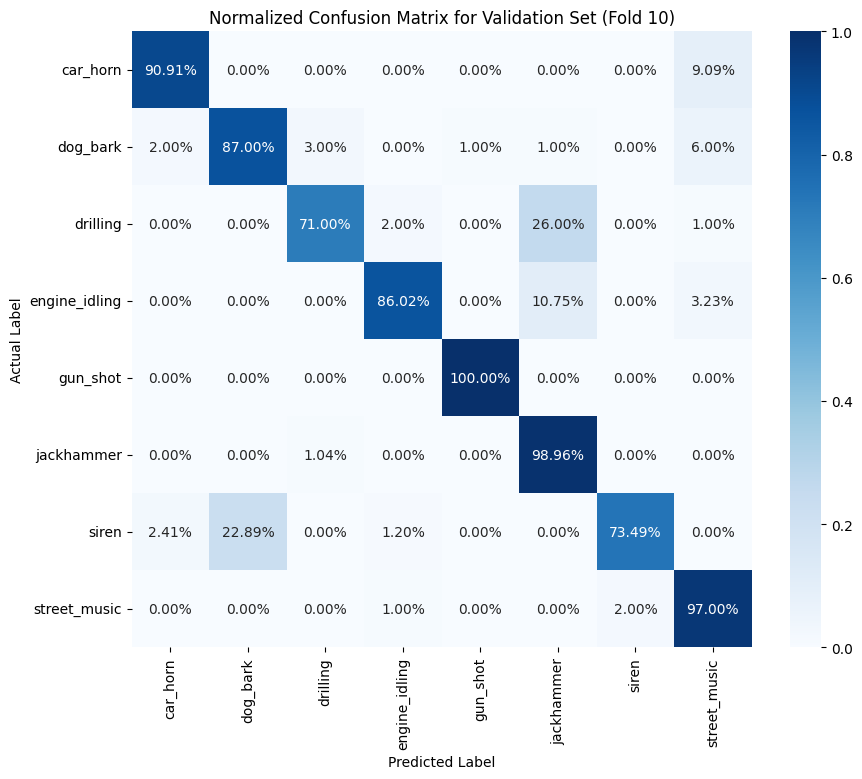

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("Running predictions on validation set (Fold 10) for analysis...")
y_probabilities = best_model.predict(X_val_norm)
y_pred = np.argmax(y_probabilities, axis=1)
y_true = y_val

class_names = [
    'car_horn',       # Index 0 (ID 1)
    'dog_bark',       # Index 1 (ID 3)
    'drilling',       # Index 2 (ID 4)
    'engine_idling',  # Index 3 (ID 5)
    'gun_shot',       # Index 4 (ID 6)
    'jackhammer',     # Index 5 (ID 7)
    'siren',          # Index 6 (ID 8)
    'street_music'    # Index 7 (ID 9)
]

print("\n--- Classification Report ---\n")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n--- Confusion Matrix (Percentages) ---")
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='.2%', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix for Validation Set (Fold 10)')
plt.show()

In [ ]:
checkpoint_path = f"{model_version}/best_model.keras"
# --- STEP 1: Load the fully trained model ---
try:
    print(f"Loading trained model from: {checkpoint_path}")
    trained_model = tf.keras.models.load_model(checkpoint_path)
    print("Trained model loaded successfully.")
except NameError:
    print("ERROR: 'checkpoint_path' not found. Make sure you ran the training cell.")
    raise

print("Building new 'inference_model' by stripping augmentation layers...")
inference_model = tf.keras.Sequential()
try:
    inference_model.add(tf.keras.layers.Input(shape=input_shape))
except NameError:
    print("ERROR: 'input_shape' not found. Make sure you ran the training cell.")
    raise

for layer in trained_model.layers:
    config = layer.get_config()
    layer_class_name = layer.__class__.__name__
    
    if layer_class_name in ["GaussianNoise", "Dropout", "InputLayer"]:
        print(f"SKIPPING layer: {layer.name} (Type: {layer_class_name})")
        continue

    print(f"ADDING layer: {layer.name} (Type: {layer_class_name})")
    inference_model.add(layer)

print("\nNew inference model summary:")
inference_model.summary()

inference_model_filename = f"{model_version}/inference_model.keras"
print(f"\nSaving new Keras model as '{inference_model_filename}'...")
inference_model.save(inference_model_filename)

rep_data_filename = f"{model_version}/rep_data.npy"
print(f"Saving representative dataset as '{rep_data_filename}'...")
try:
    num_samples = min(1000, len(X_train_norm_shuffled))
    print(f"Using {num_samples} samples for representative dataset...")
    
    rep_data = X_train_norm_shuffled[0:num_samples]
    np.save(rep_data_filename, rep_data)
except NameError:
    print("ERROR: 'X_train_norm_shuffled' not found. Run the training cell.")
    raise

print("\n" + "="*30)
print("✅ Local preparation complete!")
print("Upload these two files to Colab:")
print(f"1. {inference_model_filename}")
print(f"2. {rep_data_filename} (this is the new 1000-sample file)")
print("="*30)

Loading trained model from: v8/best_model.keras
Trained model loaded successfully.
Building new 'inference_model' by stripping augmentation layers...
ADDING layer: conv2d (Type: Conv2D)
ADDING layer: batch_normalization (Type: BatchNormalization)
ADDING layer: max_pooling2d (Type: MaxPooling2D)
ADDING layer: conv2d_1 (Type: Conv2D)
ADDING layer: batch_normalization_1 (Type: BatchNormalization)
ADDING layer: max_pooling2d_1 (Type: MaxPooling2D)
ADDING layer: conv2d_2 (Type: Conv2D)
ADDING layer: batch_normalization_2 (Type: BatchNormalization)
ADDING layer: max_pooling2d_2 (Type: MaxPooling2D)
ADDING layer: global_average_pooling2d (Type: GlobalAveragePooling2D)
SKIPPING layer: dropout (Type: Dropout)
ADDING layer: dense (Type: Dense)
ADDING layer: dense_1 (Type: Dense)

New inference model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,088 (101.91 KB)

 Trainable params: 25,864 (101.03 KB)

 Non-trainable params: 224 (896.00 B)


Saving new Keras model as 'v8/inference_model.keras'...
Saving representative dataset as 'v8/rep_data.npy'...
Using 1000 samples for representative dataset...

✅ Local preparation complete!
Upload these two files to Colab:
1. v8/inference_model.keras
2. v8/rep_data.npy (this is the new 1000-sample file)


In [14]:
# -----------------------------
# VERIFY TFLITE MODEL
# -----------------------------
output_filename = f"{model_version}/model.tflite"
print("\nVerifying TFLite model...")
interpreter = tf.lite.Interpreter(model_path=output_filename)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(f"Input details: {input_details['shape']} (shape), {input_details['dtype']} (dtype)")
print(f"Output details: {output_details['shape']} (shape), {output_details['dtype']} (dtype)")

correct_predictions = 0
num_test_samples = 100

for i in range(num_test_samples):
    sample_float = X_val_norm[i]
    expected_label = y_val[i]
    input_scale, input_zero_point = input_details['quantization']
    
    sample_int8 = (sample_float / input_scale) + input_zero_point
    sample_int8 = sample_int8.astype(input_details['dtype'])
    sample_int8 = sample_int8[np.newaxis, ...]
    
    interpreter.set_tensor(input_details['index'], sample_int8)
    interpreter.invoke()
    
    output_int8 = interpreter.get_tensor(output_details['index'])[0]
    output_scale, output_zero_point = output_details['quantization']
    output_float = (output_int8.astype(np.float32) - output_zero_point) * output_scale
    
    predicted_label = np.argmax(output_float)
    
    if predicted_label == expected_label:
        correct_predictions += 1

tflite_accuracy = (correct_predictions / num_test_samples)
print(f"\nTest accuracy on {num_test_samples} samples:")
print(f"Keras model val_accuracy: {val_acc:.4f}")
print(f"TFLite INT8 model accuracy: {tflite_accuracy:.4f}")

if abs(val_acc - tflite_accuracy) < 0.05:
    print("✅ Accuracy is consistent. Model is ready for deployment.")
else:
    print("⚠️ WARNING: Significant accuracy drop after quantization. Review your representative_dataset.")


Verifying TFLite model...
Input details: [  1 126  64   1] (shape), <class 'numpy.int8'> (dtype)
Output details: [1 8] (shape), <class 'numpy.int8'> (dtype)

Test accuracy on 100 samples:
Keras model val_accuracy: 0.8540
TFLite INT8 model accuracy: 0.7400
⚠️ WARNING: Significant accuracy drop after quantization. Review your representative_dataset.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
